### A stochastic dealer model as 2D random walk

Given simplified scenario of only two dealers $i= \{1,2\}$ with each having a bid and ask prices and the mid-price $p_i(t)$ respectively) given by the average of the two. The differnce between bid and ask prices is termed *spread* and transaction occurs iff $|p_1(t) - p_2(t)| \leq L$.

Under these rules, the market price $P$ of the transaction is the average of mid-prices $\frac{1}{2} (p_1-p_2)|_t$.

The evolution of price for a dealer is given by 1D random walk with binomially distributed displacements:

$$p_i(t + \Delta t) = p_i(t) + c f_i(t), \qquad \qquad i=1,2$$
$$f_i(t) = 
\begin{cases}
    +\Delta p & \mathrm{w.p.} \quad .5 \\
    -\Delta p & \mathrm{w.p.} \quad .5 \\
\end{cases}$$


* The dealer model can be understood as a standard 2D Random walk with absorbing boundaries
* Perform a change in variables, from $p_1(t)$ and $p_2(t)$, to the price difference $D(t)$ and average $A(t)$
$$D(t) = p_1(t) - p_2(t)$$
$$A(t) = \frac{1}{2}\big(p_1(t) + p_2(t)\big)$$

* Dynamics of $D$ and $A$ describe a 2D random walk.

$$ D(t+\Delta t) = D(t) + 
\begin{cases}
        +2 c \Delta p & \textrm{w.p.} \quad \frac{1}{4} \\
        0 & \textrm{w.p.} \quad \frac{1}{2} \\
        -2 c \Delta p & \textrm{w.p.} \quad \frac{1}{4}\\
\end{cases}$$
$$A(t+\Delta t) = A(t) + 
\begin{cases}
        +c \Delta p & \textrm{w.p.} \quad \frac{1}{4}\\
        0 & \textrm{w.p.} \quad \frac{1}{2}\\
        -c \Delta p & \textrm{w.p.} \quad \frac{1}{4}\\
\end{cases}$$
* When $D(t) = \pm L$ a transaction occurs and the random walk ends, the *particle* is absorbed by the boundary.

We can now simulate the evolution of price avarage and price difference as 2D random walk. Note that the displacements in the *'difference dimension'* are twice as large as the ones in *'average dimension'*.

In [28]:
import numpy as np  # import numpy library as np
import math         # use mathematical functions defined by the C standard
import matplotlib.pyplot as plt # import pyplot library as plt 
plt.style.use('ggplot') # use "ggplot" style for graphs
pltparams = {'legend.fontsize':16,'axes.labelsize':20,'axes.titlesize':20,
             'xtick.labelsize':12,'ytick.labelsize':12,}
plt.rcParams.update(pltparams)
% matplotlib inline

In [46]:
def logreturn(Pt, tau = 1):
    # Logarithmic retruns of price time series:
    logret = np.log(Pt[tau:]) - np.log(Pt[0:-tau])
    return logret
def normalize(data):
    # Normalize data by std to unit variance
    # <(x - <x>)^2> = 1
    return data/np.sqrt(np.var(data))
def pdf_estimate(data, bins = 50):
    hist, edges = np.histogram(data[~np.isnan(data)], bins = bins, density = True)
    centers  = edges[:-1] + np.diff(edges)/2.0 # get bar centers
    nonzero = hist > 0.0
    return hist[nonzero], centers[nonzero]

In [30]:
params={"L":.01, "c":.01, "dp":.01, "dt":.01**2} # define model parameters
def model1RW(params, p0):
    price = np.array([p0[0], p0[1]])
    cdp = params["c"] * params["dp"]
    Dt = [price[0] - price[1]]
    At = [np.average(price)]
    
    while np.abs(price[0] - price[1]) < params["L"]: # keep trading until we have exceeded the spread
        price = price + np.random.choice([-cdp,cdp], size = 2) # make a radom step
        Dt.append(price[0] - price[1])
        At.append(np.average(price))
    
    return np.array(Dt), np.array(At) - At[0] # center the average around zero        

Walk  0  : number of steps =  10755 , price change =  -0.0104000000003
Walk  1  : number of steps =  4899 , price change =  -0.00500000000017
Walk  2  : number of steps =  6498 , price change =  0.00970000000032


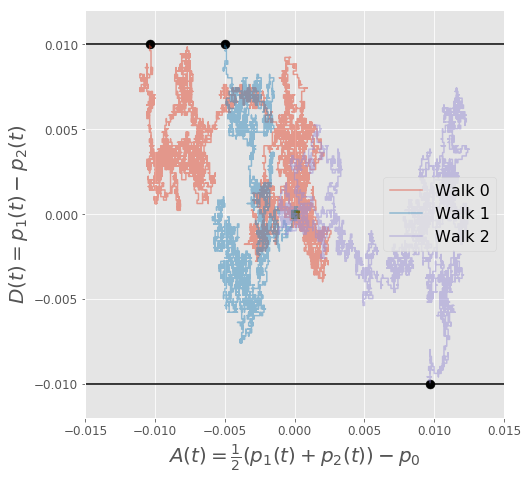

In [31]:
b

Now we make simulation for single stock and look at larger time interval. We define a *tick time*, which is incremented wenever there is a transaction.

In [32]:
params={"L":.01, "c":.01, "dp":.01, "dt":.01**2} # define model parameters
np.random.seed(5)

def model1(params, p0, numt):
    price = np.array([p0[0], p0[1]])
    cdp = params["c"] * params["dp"]
    mktprice = np.zeros(numt)
    ticktime = np.zeros(numt, dtype = np.int)
    time, tick = 0, 0
    
    while tick < numt:
        while np.abs(price[0] - price[1]) < params["L"]: # keep trading until we have exceeded the spread
            price = price + np.random.choice([-cdp,cdp], size = 2) # make a radom step
            time = time + 1
        price[:] = np.average(price) # after trade, the new starting posiiton for both is the old mktprice
        mktprice[tick] = price[0] # store the new starting price
        ticktime[tick] = time
        tick = tick +1
    
    return ticktime, mktprice       

In [38]:
num_ticks = 2500
p0 = [100.25, 100.25]

ticktime, mktprice = model1(params, p0, num_ticks)
np.savetxt("model1.txt", np.transpose([ticktime, mktprice]))

Next, we analyse the data:

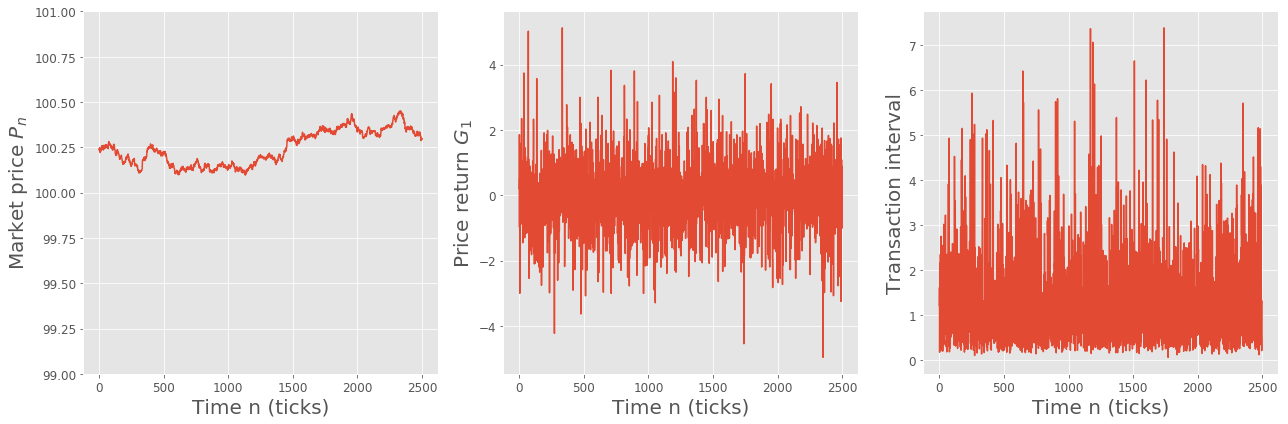

In [38]:
ticktime, mktprice = np.loadtxt("model1.txt", unpack = True)
t_interval = normalize((ticktime[1:] - ticktime[0:-1])*params["dt"]) #dt between two trades
dprice = normalize(logreturn(mktprice, tau = 1)) # log return over one tick, normalized to unit variance
fig,[ax,bx,cx]=plt.subplots(figsize=(18,6),ncols=3,subplot_kw={'xlabel':r'Time n (ticks)'})
ax.plot(mktprice)
ax.set_ylim(99,101)
ax.set_ylabel(r'Market price $P_n$')
bx.plot(dprice)
bx.set_ylabel(r'Price return $G_1$')
cx.plot(t_interval)
cx.set_ylabel(r'Transaction interval')
fig.tight_layout() # get nice spacing between plots
plt.show()

The process appears to be not Gaussian as there are peaks in price returns as big as ~5 standard deviations.

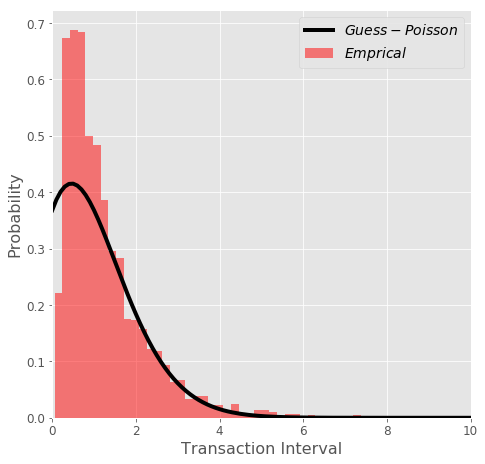

In [9]:
fig, ax = plt.subplots(1,1, figsize = (7.5, 7.5))
ax.set_xlabel("Transaction Interval", fontsize=16)
ax.set_ylabel("Probability", fontsize=16)
ax.hist(x=t_interval, bins=40, normed=True,color='r',alpha=0.5,lw=0, label = r"$Emprical$")

#Exact
from scipy.special import gamma # use n! = gamma(n+1)
kk = np.arange(0, 15, .1)
lmbd = 1
y = [(np.exp(-lmbd) * lmbd ** k) / gamma(k + 1) for k in kk]

ax.plot(kk,y,lw=4,color='k',label = r"$Guess - Poisson$")
ax.legend(fontsize=14,loc=1, framealpha=0.9)
ax.set_xlim(0,10)
plt.show()

This looks bit suspicious, do really both distributions, empirical and exact, integrate to one? 

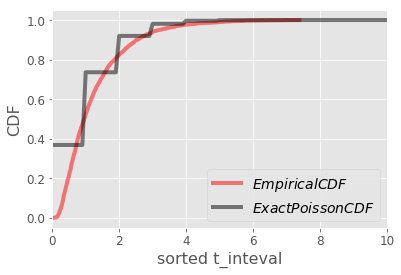

In [11]:
fig, ax = plt.subplots(1,1, figsize = (6,4))
ax.set_xlabel("sorted t_inteval", fontsize=16)
ax.set_ylabel("CDF", fontsize=16)
# Emprical
sorted_interval = np.sort(t_interval)
p_emp = 1. * np.arange(len(t_interval))/(len(t_interval) - 1)
#Exact
from scipy.stats import poisson
p_exct = poisson.cdf(kk, lmbd)

ax.plot(sorted_interval, p_emp, lw=4, color='r', alpha=0.5, label = r"$Empirical CDF$")
ax.plot(kk, p_exct, lw=4, color='k', alpha=0.5,  label = r"$Exact Poisson CDF$")

ax.legend(fontsize=14,loc=4, framealpha=0.9)
ax.set_xlim(0,10)
plt.show()

This seems plausible. We could try fitting couple of ditributions to our data to see if which ones work the best. To keep it simple, we stick to continuous distributions as the discrete ones do not have `fit` method implemented (we would have to implement this ourselves).

Using answer https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python we arrive to the following code

C:\Users\marti\Miniconda2\envs\py36\lib\site-packages\matplotlib\__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


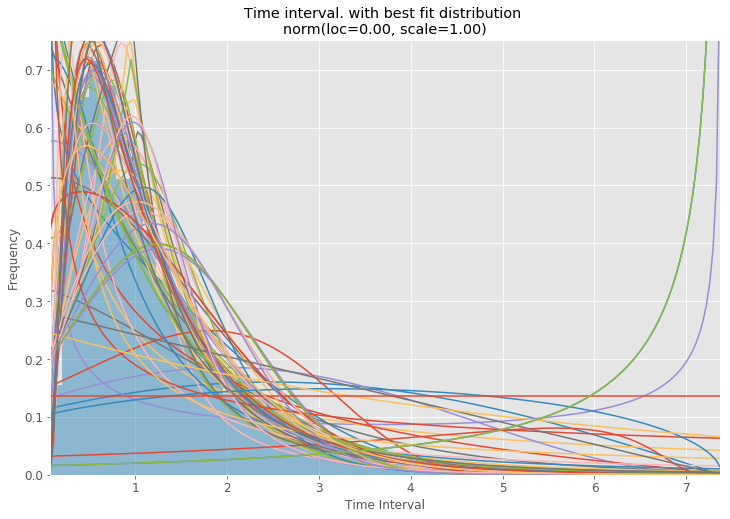

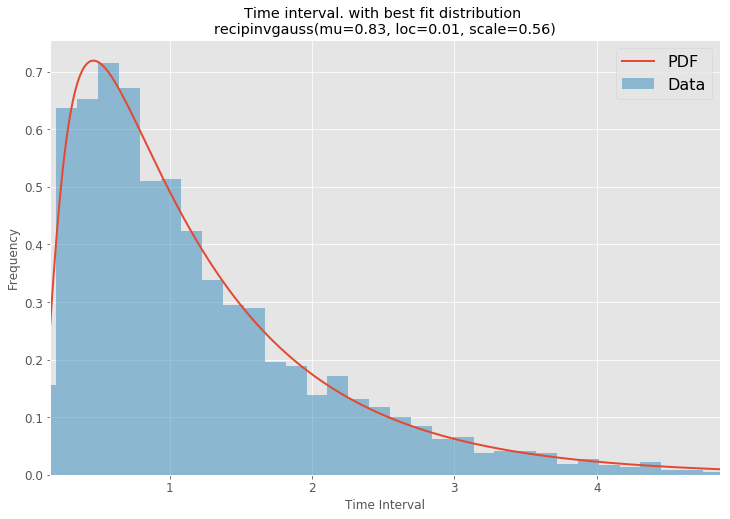

In [23]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        # st.boltzmann, st.logser, st.nbinom, st.planck, st.skellam, st.zipf, st.poisson, # discrete
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]
    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('error')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if  best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = t_interval

# Plot for comparison
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(data, bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Time interval. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Time Interval')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
ax.hist(data, bins=50, normed=True, alpha=0.5, label='Data')

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'Time interval with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Time Interval')
ax.set_ylabel('Frequency')
plt.legend()
plt.show()

We can also check the CDF:

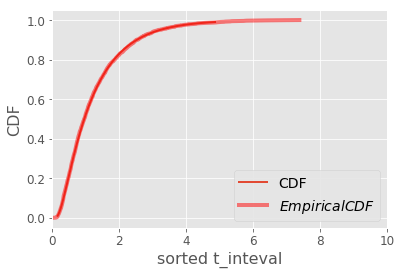

In [27]:
def make_cdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.cdf(x, loc=loc, scale=scale, *arg)
    cdf = pd.Series(y, x)

    return cdf

fig, ax = plt.subplots(1,1, figsize = (6,4))
ax.set_xlabel("sorted t_inteval", fontsize=16)
ax.set_ylabel("CDF", fontsize=16)
# Emprical
sorted_interval = np.sort(t_interval)
p_emp = 1. * np.arange(len(t_interval))/(len(t_interval) - 1)
# Best Fit
cdf = make_cdf(best_dist, best_fir_paramms)
cdf.plot(lw=2, label='CDF', legend=True, ax = ax)

ax.plot(sorted_interval, p_emp, lw=4, color='r', alpha=0.5, label = r"$Empirical CDF$")
#ax.plot(kk, p_exct, lw=4, color='k', alpha=0.5,  label = r"$Best Fit CDF$")

ax.legend(fontsize=14,loc=4, framealpha=0.9)
ax.set_xlim(0,10)
plt.show()

This indeed looks like a good fit.
BTW, the Reciprocal Inverse Gaussian Distribution is [defined as](http://jiffyclub.github.io/scipy/tutorial/stats/continuous_recipinvgauss.html):

$$
\begin{eqnarray*}
f_{RIG}\left(x;\mu\right) & = & \frac{1}{\sqrt{2\pi x}}\exp\left(-\frac{\left(1-\mu x\right)^{2}}{2x\mu^{2}}\right)\\ 
F_{RIG}\left(x;\mu\right) & = & 1-F_{IG}\left(\frac{1}{x},\mu\right)\\  & = & 1-\Phi\left(\frac{1}{\sqrt{x}}\frac{1-\mu x}{\mu}\right)-\exp\left(\frac{2}{\mu}\right)\Phi\left(-\frac{1}{\sqrt{x}}\frac{1+\mu x}{\mu}\right)
\end{eqnarray*}
$$

Adn the Inversge Gaussian Distribution is also known as [Wald distribution](https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution)

We finish returning to the simulated data and getting a different virw on the distribution.

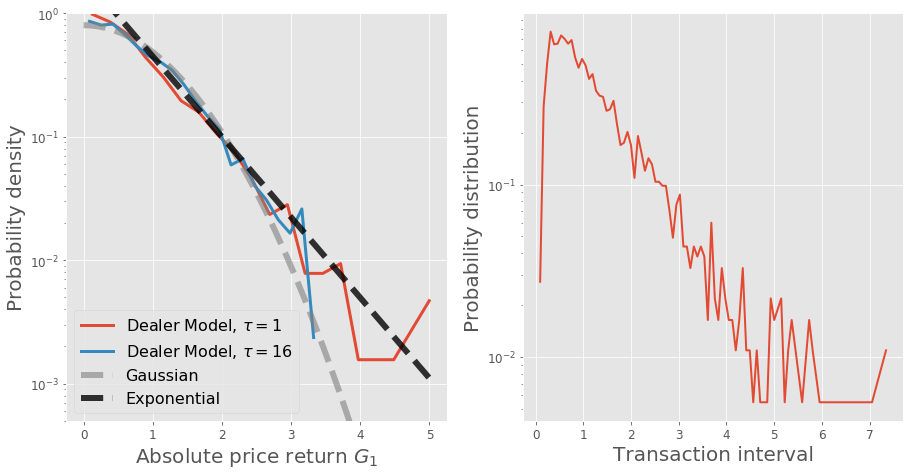

In [48]:
fig,[ax,bx] = plt.subplots(figsize=(15,7.5),ncols=2,subplot_kw={'ylabel':r'Probability distribution'})

edges,hist = pdf_estimate(np.abs(dprice),bins=20) # probability density of price change G_1 between ticks
ax.plot(hist, edges,  lw=3, label=r'Dealer Model, $\tau = 1$')

dprice16 = normalize(logreturn(mktprice, tau = 16))
edges,hist = pdf_estimate(np.abs(dprice16),bins=20) # probability density of price change G_1 between ticks
ax.plot(hist, edges,  lw=3, label=r'Dealer Model, $\tau = 16$')

x = np.linspace(0, 5)
ax.plot(x,2*np.exp(-x**2/2)/np.sqrt(2*np.pi),lw=6,ls='--',color='gray',alpha=0.6,label=r'Gaussian')
ax.plot(x, 2*np.exp(-1.5*x),lw=6,color='k',ls='--',alpha=0.8,label=r'Exponential')

ax.set_xlabel(r'Absolute price return $G_1$')
ax.set_ylabel(r'Probability density')
ax.set_ylim([5e-4,1])
ax.semilogy()
ax.legend()

edges,hist = pdf_estimate(t_interval,bins=100) # probability density of transaction time intervals between ticks
bx.plot(hist, edges, lw=2)
bx.set_xlabel(r'Transaction interval')
bx.set_ylabel(r'Probability distribution')
bx.semilogy()
plt.show()

We observe that the price return follows an exponential law. Real stocks however tend to follow a power law as shown previously. We can fix this dicsrepancy by introducing memory to the model, as described in next notebook.